In [1]:
from pyHalo.PresetModels.cdm import CDM
from pyHalo.PresetModels.wdm import WDM
from pyHalo.plotting_routines import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from copy import deepcopy
from pyHalo.truncation_models import truncation_models
from pyHalo.single_realization import Realization

np.random.seed(111)

### Tidal evolution in pyHalo

The most accurate tidal truncation model implemented in pyHalo is the one presented by https://ui.adsabs.harvard.edu/abs/2025arXiv250307728D/abstract

This is an empirical model that predicts bound masses from the properties (concentration, infall time) of subhalos at infall. The code then calculates the density profile of subhalos from the bound mass using tidal tracks.

This model is calibrate for galaxy-scale lenses with the assumption the DM halos have NFW profiles at infall. However, some of the methods used in this model can be applied more broadly (see the cell on the BOUND_MASS_PDF model below). 

In [2]:
sigma_sub = 0.3
log_10_half_mode_mass = 7.5

cdm_truncation_galacticus = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos='TRUNCATION_GALACTICUS')
wdm_truncation_galacticus = WDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
                                       log_mc=log_10_half_mode_mass,
                               truncation_model_subhalos='TRUNCATION_GALACTICUS')

lens_cosmo = cdm_truncation_galacticus.lens_cosmo


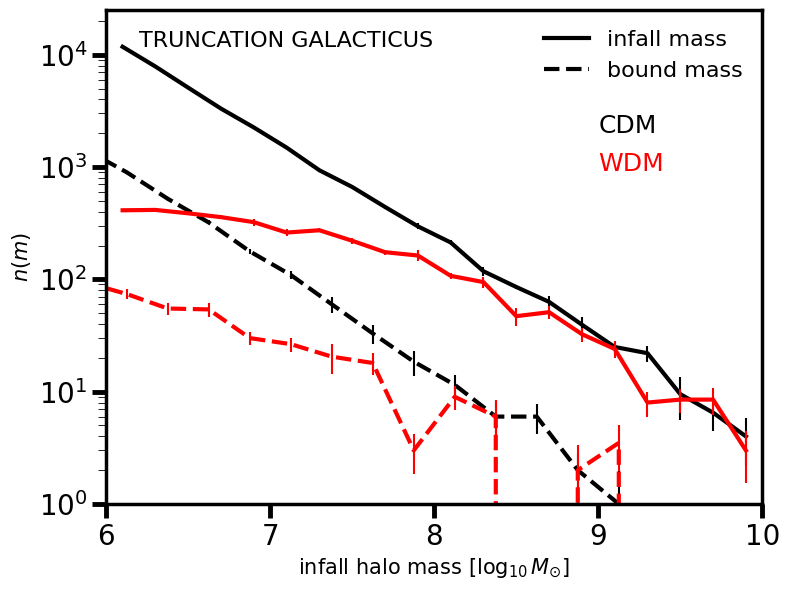

In [3]:
fig = plt.figure(1)
ax = plt.subplot(111)
fig.set_size_inches(8, 6)
kwargs_plot={'lw':3, 'label': 'infall mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'linestyle': '--', 'lw':3, 'label': 'bound mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')

kwargs_plot={'lw':3}
plot_subhalo_mass_functon(wdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(wdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')

plt.annotate('CDM', fontsize=18, color='k', xy=(0.75, 0.75), xycoords='axes fraction')
plt.annotate('WDM', fontsize=18, color='r', xy=(0.75, 0.675), xycoords='axes fraction')
plt.annotate('TRUNCATION GALACTICUS', xy=(0.05, 0.925), xycoords='axes fraction', color='k', fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.xlim(6, 10.0)
plt.ylim(1.0, 25000)
plt.tight_layout()


Text(0.5, 0, '$\\log_{10} m_{\\rm{bound}}/m_{\\rm{infall}}$')

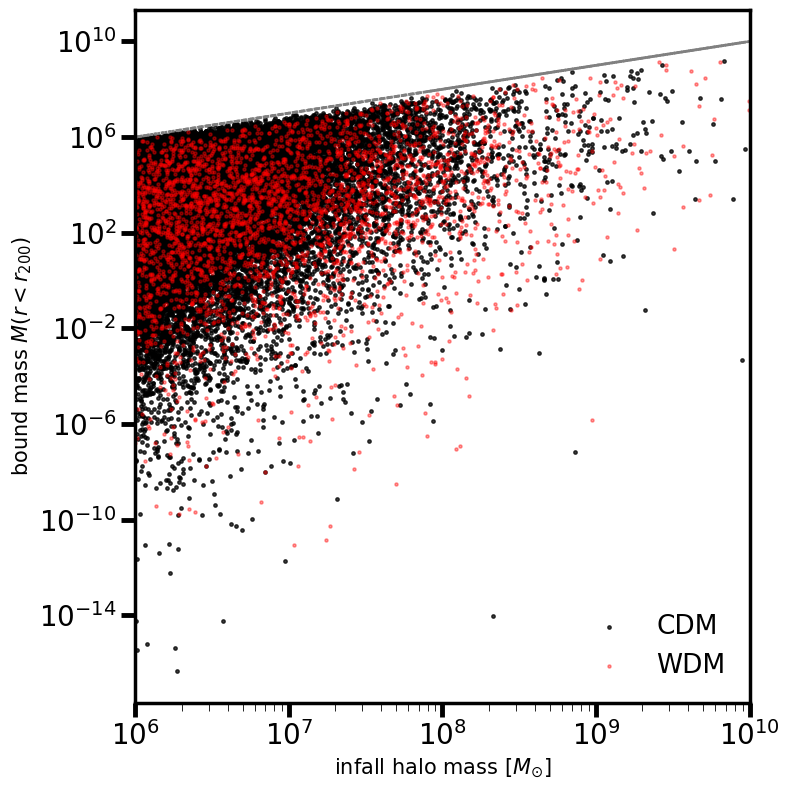

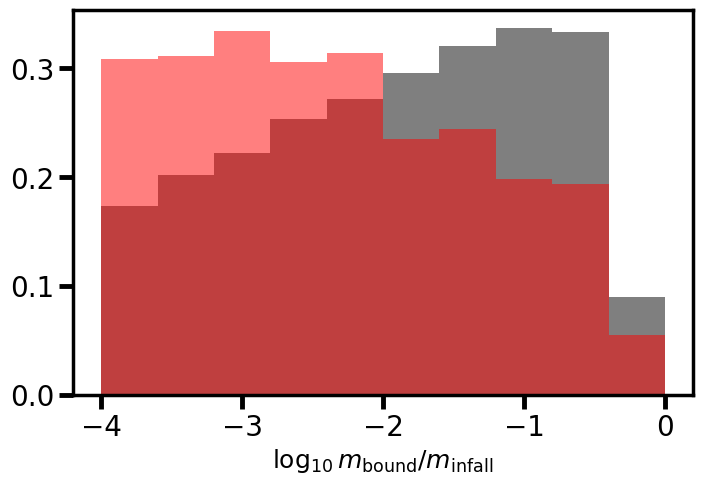

In [4]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
ax = plt.subplot(111)
kwargs_plot={'alpha': 0.75,'s': 6, 'label': 'CDM'}
plot_subhalo_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'alpha': 0.4,'s': 5, 'label': 'WDM'}
plot_subhalo_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, color='r')
ax.legend(fontsize=19, frameon=False)
ax.set_ylabel('bound mass '+r'$M\left(r<r_{200}\right)$')
plt.tight_layout()

fig = plt.figure(2)
fig.set_size_inches(8,5)
plt.hist([np.log10(halo.bound_mass/halo.mass) for halo in cdm_truncation_galacticus.halos], 
         range=(-4, 0.0),bins=10,alpha=0.5,color='k',density=True)
plt.hist([np.log10(halo.bound_mass/halo.mass) for halo in wdm_truncation_galacticus.halos], 
         range=(-4, 0.0),bins=10,alpha=0.5,color='r',density=True)
plt.xlabel(r'$\log_{10} m_{\rm{bound}}/m_{\rm{infall}}$', fontsize=18)
#plt.savefig('./galacticus_truncation_figures/bound_mass_versus_infall_mass.pdf')

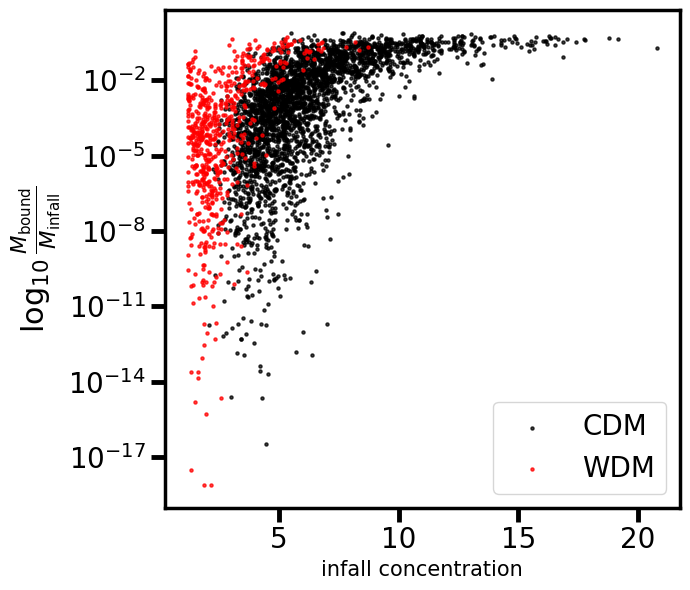

In [5]:
fig = plt.figure(1)
fig.set_size_inches(7,6)
ax = plt.subplot(111)
mass_range = [7.0, 7.5]
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'CDM'}
plot_subhalo_concentration_versus_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='k', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'WDM'}
plot_subhalo_concentration_versus_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='r', log_mlow=mass_range[0], log_mhigh=mass_range[1])
plt.tight_layout()
plt.legend(fontsize=20)
#plt.savefig('./galacticus_truncation_figures/infallc_versus_boundmass.pdf')
plt.show()



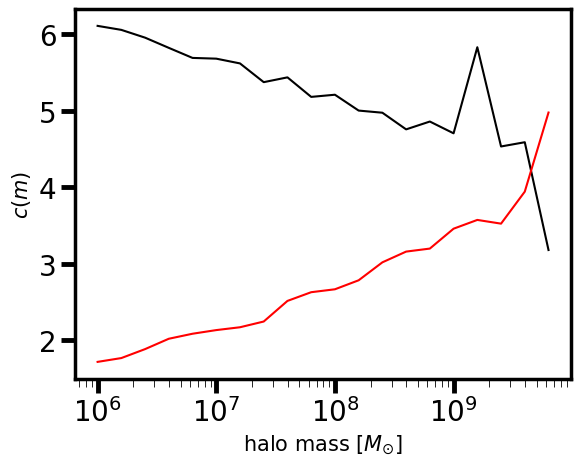

In [6]:
plt.figure(1)
ax = plt.subplot(111)
plot_concentration_mass_relation(cdm_truncation_galacticus, 0.5, ax=ax)
plot_concentration_mass_relation(wdm_truncation_galacticus, 0.5, ax=ax, color='r')

### Tidal trunction through BOUND_MASS_PDF model 

The TRUNCATION_GALACTICUS model predicts the bound mass of subhalos based on their infall concentrations, infall times, and the host halo concentration, assuming a galaxy-scale lens $M_{200} \sim 10^{13} M_{\odot}$. While this may not be appropriate for all cases (i.e. galaxy clusters) we can still use the tidal tracks to specify the density profile, given a bound mass. 

The BOUND_MASS_PDF model allows one to specify the distribution of bound masses, assuming the variable $\log_{10} \left(m_{\rm{bound}} / m_{\rm{infall}}\right)$ is a Gaussian with a mean log10_fbound_mass_mean and standard deviation log10_fbound_mass_standard_dev. 

In [7]:
from pyHalo.Halos.tidal_truncation import TrunctionBoundMassPDF

class TruncationBoundMassPDFCustom1(TrunctionBoundMassPDF):

    def __init__(self, lens_cosmo, log10_fbound_mean=-1.5, log10_fbound_standard_dev=0.5):
        super(TruncationBoundMassPDFCustom1, self).__init__(lens_cosmo, log10_fbound_mean, log10_fbound_standard_dev)

class TruncationBoundMassPDFCustom2(TrunctionBoundMassPDF):

    def __init__(self, lens_cosmo, log10_fbound_mean=-2.5, log10_fbound_standard_dev=0.5):
        super(TruncationBoundMassPDFCustom2, self).__init__(lens_cosmo, log10_fbound_mean, log10_fbound_standard_dev)

model_default = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos='BOUND_MASS_PDF')

model_1 = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos=TruncationBoundMassPDFCustom1)

model_2 = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos=TruncationBoundMassPDFCustom2)

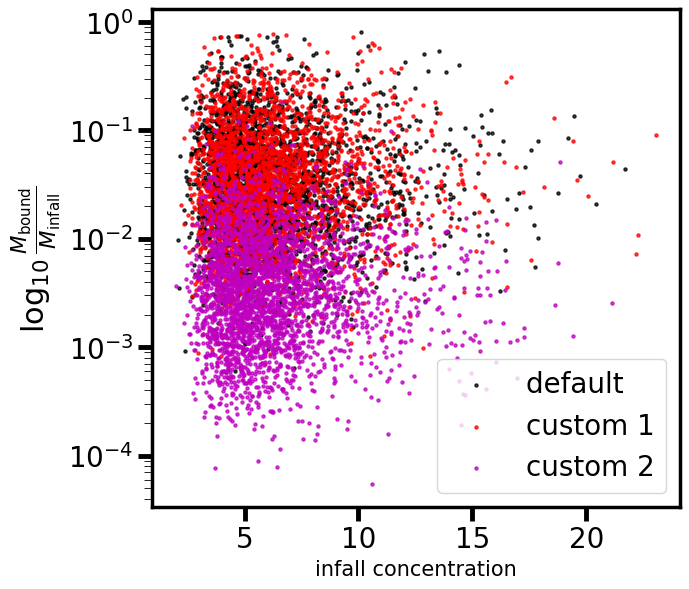

In [8]:
fig = plt.figure(1)
fig.set_size_inches(7,6)
ax = plt.subplot(111)
mass_range = [7.0, 7.5]
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'default '}
plot_subhalo_concentration_versus_bound_mass(model_default, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='k', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'custom 1'}
plot_subhalo_concentration_versus_bound_mass(model_1, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='r', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'custom 2'}
plot_subhalo_concentration_versus_bound_mass(model_2, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='m', log_mlow=mass_range[0], log_mhigh=mass_range[1])
plt.tight_layout()
plt.legend(fontsize=20)
#plt.savefig('./galacticus_truncation_figures/infallc_versus_boundmass.pdf')
plt.show()

